### train mnist

In [3]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import torch

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        # 初始化卷积层1，输入通道数为3，输出通道数为32，卷积核大小为3x3，步长为1
        self.conv1 = nn.Conv2d(3, 32, 3, 1)      
        # 初始化卷积层2，输入通道数为32，输出通道数为64，卷积核大小为3x3，步长为1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)   
        # 初始化dropout层1，随机舍弃25%的神经元
        self.dropout1 = nn.Dropout(0.25)   
        # 初始化dropout层2，随机舍弃50%的神经元
        self.dropout2 = nn.Dropout(0.5)     
        # 初始化全连接层1，输入尺寸为9216，输出尺寸为128
        self.fc1 = nn.Linear(9216, 128)     
        # 初始化全连接层2，输入尺寸为128，输出尺寸为10
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # 在输入图像上应用第一层卷积
        x = self.conv1(x)      
        # 应用ReLU激活函数
        x = F.relu(x)     
        # 在特征图上应用第二层卷积
        x = self.conv2(x)      
      # 应用ReLU激活函数
        x = F.relu(x)       
        # 对特征图进行最大池化，窗口大小为2x2
        x = F.max_pool2d(x, 2)      
        # 应用第一个dropout层
        x = self.dropout1(x)       
        # 对特征图展平成一维张量
        x = torch.flatten(x, 1)       
        # 应用全连接层1
        x = self.fc1(x)       
        # 应用ReLU激活函数
        x = F.relu(x)        
        # 应用第二个dropout层
        x = self.dropout2(x)       
        # 应用全连接层2
        x = self.fc2(x)        
        # 应用log_softmax激活函数
        output = F.log_softmax(x, dim=1)      
        return output

class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        net = models.mobilenet_v3_small(pretrained=False)
        #引入MobileNet-v3-small预训练模型并在其基础上进行微调。将pretrained参数设置为False表示不使用预训练权重,而是重新随机初始化权重
        self.trunk = nn.Sequential(*(list(net.children())[:-2]))
        #除了最后两层fc层之外的所有层,并以Sequential方式进行排列,即"backbone"
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        #定义一个自适应平均池化层,输出大小为1。该层的作用是将任意大小的输入张量转换为固定大小的输出张量。
        
        self.fc = nn.Sequential(
            nn.Linear(576, 10, bias=True),
            nn.LogSoftmax(dim=1)
        )
        #定义一个包含两个线性层和一个LogSoftmax层的序列模块。这是MobileNet模型的分类器

    def forward(self, x):
        #得到一个10维的概率向量。返回值为x
        x = self.trunk(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main(k=0):
    # Training settings

    no_cuda = False
    seed = 1111
    batch_size = 128
    test_batch_size = 1000
    lr = 0.01
    save_model = True
    epochs = 2
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': batch_size,'shuffle':True}
    test_kwargs = {'batch_size': test_batch_size,'shuffle':True}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': False}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    dataset2 = datasets.ImageFolder('mnist/testing',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs, num_workers=8)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    if k == 0:
    #model = Net().to(device)
        model = MobileNet().to(device)
    else:
        model = Net.to(device)
        
    optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=lr)

    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    for epoch in range(1, epochs + 1):
        train( model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_mobile.pt")
    
    
    return model



In [4]:
m1 = main()
m2 = main(1)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.370431
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.206130
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.107401
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.156687
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.140761

Test set: Average loss: 1.9024, Accuracy: 6957/10000 (70%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.055387
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.081787
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.071369
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.074914
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.042217

Test set: Average loss: 0.0797, Accuracy: 9766/10000 (98%)



AttributeError: 'torch.device' object has no attribute '_apply'

### how's our model

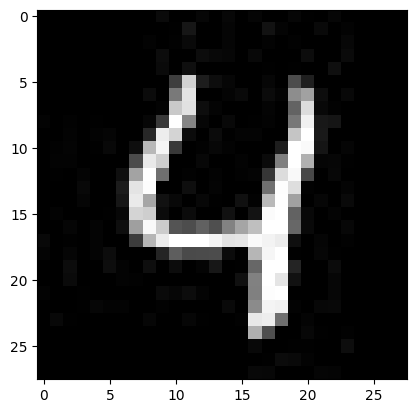

In [5]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

four_img = Image.open("mnist/pic/4.jpg")
four_img = four_img.convert('RGB')
transform=transforms.Compose([
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


four_tensor = transform(four_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(four_tensor[0].numpy().transpose(1,2,0))


In [6]:

def cnn_eval(tensor):
    model=Net()
    model.load_state_dict(torch.load("mnist_cnn.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))

def mobile_eval(tensor):
    model=MobileNet()
    model.load_state_dict(torch.load("mnist_mobile.pt"))
    #该模型的权重参数从"mnist_mobile.pt"文件中加载进来
    model.eval()
    #设定评估模式
    print(torch.argmax(model(tensor)))
    #对输入张量在模型上的输出进行求解,并返回最大值所在的元素下标

cnn_eval(norm(four_tensor))
mobile_eval(norm(four_tensor))

tensor(4)
tensor(4)


### attack 

In [33]:
# import torch.optim as optim


# def l_infinity_pgd(model, tensor, gt,epsilon=30./255, target=None,iter=100, show=False,early_stop=True):
#     '''
#     params:
#         model:需要使用的模型,用于对输入张量进行分类。
#         tensor:输入张量,即要添加对抗噪声的原始数据。
#         gt:真实标签,即输入张量所属类别的标签。
#         epsilon:用于控制对抗噪声强度的超参,表示添加的对抗噪声的范围。
#         target:目标类别,如果攻击方指定了目标类别,则生成的对抗样本将被分类为该目标类别。
#         iter:迭代次数,指PGD算法进行的迭代次数。
#         show:是否展示原始输入张量和加入对抗噪声后的张量。
#     '''
#     # 创建一张和输入张量tensor形状相同的全零Delta张量，并设置requires_grad参数为True，以便计算梯度
#     delta = torch.zeros_like(tensor, requires_grad=True)
#     # 使用SGD优化器来更新Delta张量，学习率为10
#     opt = optim.SGD([delta], lr=10)

#     for t in range(iter):
#         # 获取带噪声的输入张量
#         noisy_tensor = norm(tensor + delta)
#         # 使用模型对带噪声的输入进行预测
#         pred = model(noisy_tensor)
#         # 如果没有指定目标类别，则将目标类别设为gt（即输入张量的真实标签）
#         if target is None:
#             # 计算交叉熵损失
#             loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
#         else:
#             # 否则，将目标类别设为target，并计算多分类交叉熵损失
#             loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt])) \
#                 + nn.CrossEntropyLoss()(pred, torch.LongTensor([target]))
                
#         # if early_stop:
#         #     # 如果对抗样本已经被成功分类为目标类别，则提前结束迭代
#         #     if target is not None and torch.argmax(pred).item() == target:
#         #         print("Target class is successfully attacked in %d iterations." % t)
#         #         break
            
#         #     # 当损失值达到某个阈值时，可以提前结束迭代
#         #     if t > 10 and loss.item() < 1e-5:
#         #         print("Early stop at iteration %d with loss %.5f." % (t, loss.item()))
#         #         break
            
#         # 每10轮输出一次损失
#         if t % 10 == 0:
#             print(t, loss.item())   

#         # 对损失进行反向传播和优化器更新
#         opt.zero_grad()
#         #因为loss都是使得变小的,以有目标攻击而言：
#         #和原目标的loss取负，则会让原来的正数变得很大，即和源标签差距很大
#         #和新目标的loss取正，则会让这个图片越来越接近 
#         loss.backward()
#         opt.step()
#         # 将Delta张量的取值范围限制在[-epsilon, epsilon]之间
#         delta.data.clamp_(-epsilon, epsilon)

#     # # 输出真实类别的概率
#     # print("True class probability:", nn.Softmax(dim=1)(pred))
#     # # 在最后一轮迭代结束后，使用cnn_eval()函数对加入对抗样本的张量进行分类并输出结果
#     # cnn_eval(noisy_tensor)

#     # 在show=True的情况下，将原始输入张量和加入对抗噪声后的张量展示在一张图中
#     if show:
#         f,ax = plt.subplots(1,2, figsize=(10,5))
#         ax[0].imshow((delta)[0].detach().numpy().transpose(1,2,0))
#         ax[1].imshow((tensor + delta)[0].detach().numpy().transpose(1,2,0))
    
#     # 返回加入对抗噪声后的张量
#     return tensor + delta

# #x= l_infinity_pgd(m1,four_tensor,4)
# #为了训练一个好的delta噪声

import torch.optim as optim


def l_infinity_pgd(model, tensor, gt,epsilon=30./255, target=None,iter=50, show=True):
    delta = torch.zeros_like(tensor, requires_grad=True)
    opt = optim.SGD([delta], lr=10)

    for t in range(iter):
        pred = model(norm(tensor + delta))
        if target is None:
            loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
        else:
            loss = loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
            + nn.CrossEntropyLoss()(pred, torch.LongTensor([target]))
        if t % 10 == 0:
            print(t, loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)

    # print("True class probability:", nn.Softmax(dim=1)(pred))
    # cnn_eval(norm(tensor+delta))

    # if show:
    #     f,ax = plt.subplots(1,2, figsize=(10,5))
    #     ax[0].imshow((delta)[0].detach().numpy().transpose(1,2,0))
    #     ax[1].imshow((tensor + delta)[0].detach().numpy().transpose(1,2,0))
    
    return tensor + delta

x= l_infinity_pgd(m1,four_tensor,4)

0 -0.005340831819921732
10 -8.340304374694824
20 -11.23378849029541
30 -4.256566047668457
40 -11.007400512695312


In [14]:
def l_infinity_pgd_new(model, tensor, gt, epsilon=30./255, target=None, iter=1000, show=False):
    # 创建一张和输入张量tensor形状相同的全零Delta张量，并设置requires_grad参数为True，以便计算梯度
    delta = torch.zeros_like(tensor, requires_grad=True)
    # 使用Adam优化器来更新Delta张量，学习率为0.01
    opt = optim.Adam([delta], lr=10)
    pred = norm(tensor + delta)
    for t in range(iter):
        # 获取带噪声的输入张量
        noisy_tensor = norm(tensor + delta)
        # 使用模型对带噪声的输入进行预测
        pred = model(noisy_tensor)
        # 如果没有指定目标类别，则将目标类别设为gt（即输入张量的真实标签）
        if target is None:
            # 计算交叉熵损失
            loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
        else:
            # 否则，将目标类别设为target，并计算KL散度损失
            loss = -nn.KLDivLoss(reduction='batchmean')(nn.LogSoftmax(dim=1)(pred), 
                torch.softmax(torch.ones_like(pred)*(-10), dim=1)) \
                + nn.KLDivLoss(reduction='batchmean')(nn.LogSoftmax(dim=1)(pred), 
                torch.softmax(torch.ones_like(pred)*(1000), dim=1))
        # 输出当前轮的loss
        print(t, loss.item())   

        # 对损失进行反向传播和优化器更新，同时添加L2正则化项
        opt.zero_grad()
        loss.backward()
        opt.step()
        delta.grad = torch.clamp(delta.grad, -1, 1)
        delta.data.add_(delta.grad.sign(), alpha=0.01)
        delta.data.clamp_(-epsilon, epsilon)
        delta.grad.zero_()
        
        # 如果当前的对抗噪声已经具有足够的攻击性，可以提前停止迭代
        if (pred.max(1)[1] == gt).sum().item() == 0:
            break

    
    # 输出真实类别的概率
    print("True class probability:", nn.Softmax(dim=1)(pred))
    # 在最后一轮迭代结束后，使用model对加入对抗样本的张量进行分类并输出结果
    model.eval()
    cnn_eval(norm(tensor+delta))

    # 在show=True的情况下，将原始输入张量和加入对抗噪声后的张量展示在一张图中
    if show:
        f,ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].imshow((delta)[0].detach().numpy().transpose(1,2,0))
        ax[1].imshow((tensor + delta)[0].detach().numpy().transpose(1,2,0))
    
    # 返回加入对抗噪声后的张量
    return tensor + delta

x= l_infinity_pgd_new(m1,four_tensor,4)
#为了训练一个好的delta噪声

0 -0.005340831819921732
1 -4.022019386291504
True class probability: tensor([[7.0637e-04, 7.5850e-05, 1.7061e-03, 6.3855e-03, 1.7917e-02, 7.6352e-02,
         1.0402e-03, 8.9610e-03, 4.7285e-02, 8.3957e-01]],
       grad_fn=<SoftmaxBackward0>)
tensor(4)


## targeted 

tensor(7)


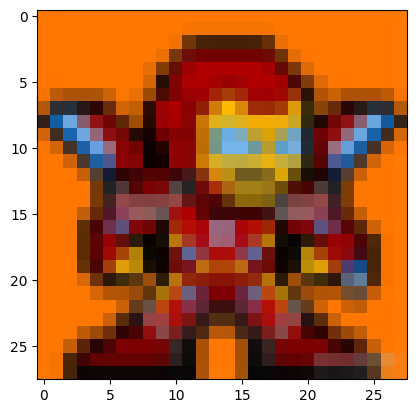

In [7]:
import torch.optim as optim

rem_img = Image.open("mnist/pic/tienan.jpeg")
rem_img = rem_img.convert('RGB')
transform=transforms.Compose([
    transforms.Resize((28,28))  ,
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


rem_tensor = transform(rem_img)[None,:,:,:]
cnn_eval(norm(rem_tensor))
plt.imshow(rem_tensor[0].numpy().transpose(1,2,0))


0 -1.802835464477539
10 -7.8328328132629395
20 -7.247197151184082
30 -6.975734710693359
40 -7.11012077331543
50 -7.476364612579346
60 -7.127001762390137
70 -7.313808917999268
80 -7.838662624359131
90 -7.371750354766846
100 -7.207711696624756
110 -8.281322479248047
120 -6.558288097381592
130 -7.4528374671936035
140 -7.125760555267334
True class probability: tensor([[5.5829e-04, 1.1553e-03, 9.9452e-01, 1.0446e-03, 9.9565e-04, 8.2892e-05,
         3.1628e-04, 3.9695e-04, 8.6068e-04, 7.2871e-05]],
       grad_fn=<SoftmaxBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(7)


tensor([[[[ 1.0745,  1.0784,  0.9216,  ...,  0.9216,  0.9216,  1.0745],
          [ 1.0784,  1.0784,  1.0784,  ...,  1.0784,  1.0784,  1.0784],
          [ 1.0535,  0.9216,  1.0046,  ...,  0.9216,  0.9971,  1.0784],
          ...,
          [ 1.0784,  1.0667,  0.8510,  ...,  0.8581,  1.0667,  0.9216],
          [ 1.0784,  0.8824,  0.2157,  ...,  0.3412,  0.8968,  0.9576],
          [ 1.0745,  0.8824,  0.2000,  ...,  0.4196,  1.0078,  0.9850]],

         [[ 0.3922,  0.3882,  0.3882,  ...,  0.4705,  0.3882,  0.5529],
          [ 0.5451,  0.5451,  0.5451,  ...,  0.5451,  0.3882,  0.5529],
          [ 0.3882,  0.3882,  0.5451,  ...,  0.5451,  0.4265,  0.5529],
          ...,
          [ 0.5213,  0.5412,  0.4510,  ...,  0.4549,  0.5321,  0.4114],
          [ 0.5451,  0.3725,  0.0667,  ...,  0.3882,  0.4905,  0.5247],
          [ 0.5529,  0.5373,  0.0667,  ...,  0.1481,  0.4966,  0.4886]],

         [[ 0.0863, -0.0745, -0.0745,  ..., -0.0745, -0.0745, -0.0627],
          [ 0.0824,  0.0824,  

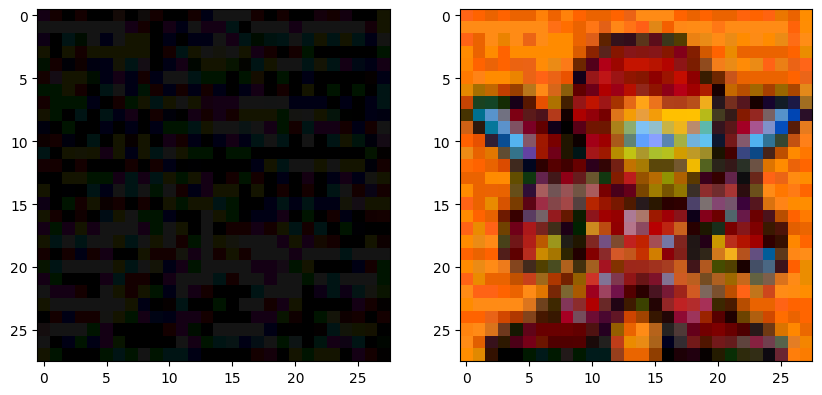

In [9]:

import torch.optim as optim

l_infinity_pgd(m1,rem_tensor,7,20./255,6,150)

### 生成对抗数据

In [36]:
# import os
# from torchvision.utils import save_image

# # 定义函数 create_adv_dataset()，用于生成对抗样本数据集
# def create_adv_dataset():
#     # 定义图像变换 transform，将 PIL.Image 或 numpy.ndarray 格式的图像转换为张量
#     transform = transforms.Compose([transforms.ToTensor()])
    
#     # 加载 MNIST 数据集，其中 'mnist/training' 为数据集路径
#     dataset1 = datasets.ImageFolder('mnist/training', transform=transform)
    
#     # 定义 DataLoader，用于加载数据。其中 batch_size 指定批量大小，num_workers 指定线程数量
#     train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1, shuffle=True, num_workers=8)
    
#     # 定义变量 attack_target，表示攻击目标，初始值为 0
#     attack_target = 0 

#     # 遍历每一个 batch
#     for batch_idx, (data, target) in enumerate(train_loader):
#         # 确定当前攻击目标
#         attack_target = batch_idx // 100
        
#         # 如果目标类别与攻击目标相同，跳过此次循环
#         if target == attack_target:
#             continue
            
#         # 如果攻击目标无法实现
#         if attack_target > 9:
#             break
        
#         # 实例化一个 Net() 类型的模型对象
#         model = Net()
        
#         # 加载预训练的模型参数，即 "mnist_cnn.pt" 文件
#         model.load_state_dict(torch.load("mnist_cnn.pt"))
        
#         # 将模型置为评估模式
#         model.eval()
        
#         # 调用 l_infinity_pgd() 函数，生成对抗样本数据
#         adv_img = l_infinity_pgd(model, data, target, 35./255, attack_target, 50, False)
        
#         # 定义图片保存路径
#         # 一个使用原标签，一个使用攻击标签
#         image_dir_1 = os.path.join('mnist/adv_ori_label', str(target.item()))
#         image_dir_2 = os.path.join('mnist/adv_adv_label', str(attack_target))
        
#         # 如果路径不存在，则创建此路径
#         if not os.path.exists(image_dir_1):
#             os.makedirs(image_dir_1)
#         if not os.path.exists(image_dir_2):
#             os.makedirs(image_dir_2)
        
#         # 将对抗样本保存为 jpg 格式的图片文件，分别存储到 'mnist/adv_ori_label' 和 'mnist/adv_adv_label' 目录下
#         save_image(adv_img, os.path.join(image_dir_1, str(batch_idx) + '.jpg'))
#         save_image(adv_img, os.path.join(image_dir_2, str(batch_idx) + '.jpg'))  

# create dataset
import os
from torchvision.utils import save_image
def create_adv_dataset():
    transform=transforms.Compose([
        transforms.ToTensor()
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,batch_size=1, shuffle=True, num_workers=8)
    
    attack_target = 0 
    for batch_idx, (data, target) in enumerate(train_loader):
        attack_target = batch_idx//100
        if target== attack_target:
            continue
        if attack_target>9:
            break
        model=Net()
        model.load_state_dict(torch.load("mnist_cnn.pt"))
        model.eval()
        adv_img = l_infinity_pgd(model,data,target,35./255,attack_target,False)
        image_dir_1 = os.path.join('mnist/adv_ori_label',str(target.item()))
        image_dir_2 = os.path.join('mnist/adv_adv_label',str(attack_target))
        if not os.path.exists(image_dir_1):
            os.makedirs(image_dir_1)
        if not os.path.exists(image_dir_2):
            os.makedirs(image_dir_2)
        
        save_image(adv_img, os.path.join(image_dir_1,str(batch_idx)+'.jpg'))
        save_image(adv_img, os.path.join(image_dir_2,str(batch_idx)+'.jpg'))

create_adv_dataset()    

### 看看模型

In [37]:

test_transform=transforms.Compose([
        #transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  
dataset1 = datasets.ImageFolder('mnist/testing',transform=test_transform)
dataset2 = datasets.ImageFolder('mnist/adv_ori_label',transform=test_transform)
dataset3 = datasets.ImageFolder('mnist/adv_adv_label',transform=test_transform)

test_loader1 = torch.utils.data.DataLoader(dataset1, shuffle=False,batch_size=100)
test_loader2 = torch.utils.data.DataLoader(dataset2, shuffle=False,batch_size=100)
test_loader3 = torch.utils.data.DataLoader(dataset3, shuffle=False,batch_size=100)

model=Net()
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

test(model, 'cpu', test_loader1)
test(model, 'cpu', test_loader2)
#test(model, 'cpu', test_loader3)

model=MobileNet()
model.load_state_dict(torch.load("mnist_mobile.pt"))
model.eval()

test(model, 'cpu', test_loader1)
test(model, 'cpu', test_loader2)
#test(model, 'cpu', test_loader3)
#这是没有意义的，因为模型的鲁棒可能让他能抵抗这次误导，评测这个导致没有任何作用




Test set: Average loss: 0.0369, Accuracy: 9871/10000 (99%)


Test set: Average loss: 0.0310, Accuracy: 891/897 (99%)



In [ ]:
# defense
# denoise renoise 
# detection 
# adversrial training
